# Ensemble Optimization for Robust Pulses

In [1]:
# NBVAL_IGNORE_OUTPUT
%load_ext watermark
import os
import qutip
import numpy as np
import scipy
import matplotlib
import matplotlib.pylab as plt
import krotov
from qutip import Qobj
import pickle

%watermark -v --iversions

numpy            1.17.2
matplotlib.pylab 1.17.2
krotov           1.0.0-dev
qutip            4.4.1
scipy            1.3.1
matplotlib       3.1.2
CPython 3.7.3
IPython 7.10.1


$\newcommand{tr}[0]{\operatorname{tr}}
\newcommand{diag}[0]{\operatorname{diag}}
\newcommand{abs}[0]{\operatorname{abs}}
\newcommand{pop}[0]{\operatorname{pop}}
\newcommand{aux}[0]{\text{aux}}
\newcommand{opt}[0]{\text{opt}}
\newcommand{tgt}[0]{\text{tgt}}
\newcommand{init}[0]{\text{init}}
\newcommand{lab}[0]{\text{lab}}
\newcommand{rwa}[0]{\text{rwa}}
\newcommand{bra}[1]{\langle#1\vert}
\newcommand{ket}[1]{\vert#1\rangle}
\newcommand{Bra}[1]{\left\langle#1\right\vert}
\newcommand{Ket}[1]{\left\vert#1\right\rangle}
\newcommand{Braket}[2]{\left\langle #1\vphantom{#2}\mid{#2}\vphantom{#1}\right\rangle}
\newcommand{ketbra}[2]{\vert#1\rangle\!\langle#2\vert}
\newcommand{op}[1]{\hat{#1}}
\newcommand{Op}[1]{\hat{#1}}
\newcommand{dd}[0]{\,\text{d}}
\newcommand{Liouville}[0]{\mathcal{L}}
\newcommand{DynMap}[0]{\mathcal{E}}
\newcommand{identity}[0]{\mathbf{1}}
\newcommand{Norm}[1]{\lVert#1\rVert}
\newcommand{Abs}[1]{\left\vert#1\right\vert}
\newcommand{avg}[1]{\langle#1\rangle}
\newcommand{Avg}[1]{\left\langle#1\right\rangle}
\newcommand{AbsSq}[1]{\left\vert#1\right\vert^2}
\newcommand{Re}[0]{\operatorname{Re}}
\newcommand{Im}[0]{\operatorname{Im}}
\newcommand{toP}[0]{\omega_{12}}
\newcommand{toS}[0]{\omega_{23}}$

This example revisits the [Optimization of a State-to-State Transfer in a
Lambda System in the RWA](02_example_lambda_system_rwa_complex_pulse.ipynb),
attempting to make the control pulses robustness with respect to variations in
the pulse amplitude, through "ensemble optimization".

**Note**: This notebook uses some parallelization features (`qutip.parallel_map`/`multiprocessing.Pool`). Unfortunately, on Windows, `multiprocessing.Pool` does not work correctly for functions defined in a Jupyter notebook (due to the [`spawn` method](https://docs.python.org/3/library/multiprocessing.html#contexts-and-start-methods) being used on Windows, instead of Unix-`fork`, see also https://stackoverflow.com/questions/45719956). We therefore replace `parallel_map` with `serial_map` when running on Windows.

In [2]:
import sys
if sys.platform == 'win32':
    from qutip import serial_map as parallel_map
else:
    from qutip import parallel_map

## Control objectives for population transfer in the Lambda system

As in the original example, we define the Hamiltonian for a Lambda system in
the rotating wave approximation, like this:

![Lambda system considered in this notebook](energylevels.png)

We set up the control fields and the Hamiltonian exactly as before:

In [3]:
def Omega_P1(t, args):
    """Guess for the real part of the pump pulse"""
    Ω0 = 5.0
    return Ω0 * krotov.shapes.blackman(t, t_start=2.0, t_stop=5.0)


def Omega_P2(t, args):
    """Guess for the imaginary part of the pump pulse"""
    return 0.0


def Omega_S1(t, args):
    """Guess for the real part of the Stokes pulse"""
    Ω0 = 5.0
    return Ω0 * krotov.shapes.blackman(t, t_start=0.0, t_stop=3.0)


def Omega_S2(t, args):
    """Guess for the imaginary part of the Stokes pulse"""
    return 0.0

In [4]:
tlist = np.linspace(0, 5, 500)

In [5]:
def hamiltonian(E1=0.0, E2=10.0, E3=5.0, omega_P=9.5, omega_S=4.5):
    """Lambda-system Hamiltonian in the RWA"""

    # detunings
    ΔP = E1 + omega_P - E2
    ΔS = E3 + omega_S - E2

    H0 = Qobj([[ΔP, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, ΔS]])

    HP_re = -0.5 * Qobj([[0.0, 1.0, 0.0], [1.0, 0.0, 0.0], [0.0, 0.0, 0.0]])
    HP_im = -0.5 * Qobj([[0.0, 1.0j, 0.0], [-1.0j, 0.0, 0.0], [0.0, 0.0, 0.0]])

    HS_re = -0.5 * Qobj([[0.0, 0.0, 0.0], [0.0, 0.0, 1.0], [0.0, 1.0, 0.0]])
    HS_im = -0.5 * Qobj([[0.0, 0.0, 0.0], [0.0, 0.0, 1.0j], [0.0, -1.0j, 0.0]])

    return [
        H0,
        [HP_re, Omega_P1],
        [HP_im, Omega_P2],
        [HS_re, Omega_S1],
        [HS_im, Omega_S2],
    ]

In [6]:
H = hamiltonian()

The control objective is the realization of a phase sensitive $\ket{1}
\rightarrow \ket{3}$ transition in the lab frame. Thus, in the rotating frame,
we must take into account an additional phase factor.

In [7]:
ket1 = qutip.Qobj(np.array([1.0, 0.0, 0.0]))
ket2 = qutip.Qobj(np.array([0.0, 1.0, 0.0]))
ket3 = qutip.Qobj(np.array([0.0, 0.0, 1.0]))

In [8]:
def rwa_target_state(ket3, E2=10.0, omega_S=4.5, T=5):
    return np.exp(1j * (E2 - omega_S) * T) * ket3

In [9]:
psi_target = rwa_target_state(ket3)

In [10]:
objective = krotov.Objective(initial_state=ket1, target=psi_target, H=H)
objectives = [objective]
objectives

[Objective[|Ψ₀(3)⟩ to |Ψ₁(3)⟩ via [H₀[3,3], [H₁[3,3], u₁(t)], [H₂[3,3], u₂(t)], [H₃[3,3], u₃(t)], [H₄[3,3], u₄(t)]]]]

## Robustness to amplitude fluctuations

A potential source of error is fluctuations in the pulse amplitude between
different runs of the experiment. To account for this, the `hamiltonian`
function above include a parameter `mu` that scales the pulse amplitudes by the
given factor.

We can analyze the result of the [Optimization of a State-to-State Transfer in
a Lambda System in the RWA](02_example_lambda_system_rwa_complex_pulse.ipynb)
with respect to such fluctuations. We load the earlier optimization result from
disk, and verify that the optimized controls produce the $\ket{1} \rightarrow
\ket{3}$ transition as desired.

In [11]:
opt_result_unperturbed = krotov.result.Result.load(
    'lambda_rwa_opt_result.dump', objectives=[objective]
)

In [12]:
proj1 = qutip.ket2dm(ket1)
proj2 = qutip.ket2dm(ket2)
proj3 = qutip.ket2dm(ket3)

In [13]:
opt_unperturbed_dynamics = (
    opt_result_unperturbed
    .optimized_objectives[0]
    .mesolve(tlist, e_ops=[proj1, proj2, proj3])
)

In [14]:
def plot_population(result):
    fig, ax = plt.subplots()
    ax.plot(result.times, result.expect[0], label='1')
    ax.plot(result.times, result.expect[1], label='2')
    ax.plot(result.times, result.expect[2], label='3')
    ax.legend()
    ax.set_xlabel('time')
    ax.set_ylabel('population')
    plt.show(fig)

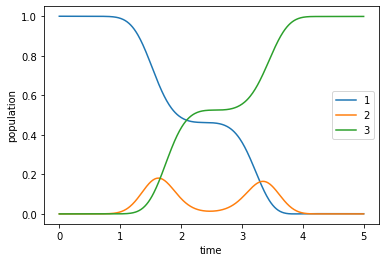

In [15]:
plot_population(opt_unperturbed_dynamics)

Now we can analyze how robust this control is for variations of ±20% of the
pulse amplitude. Numerically, this is achieved by scaling the control
Hamiltonians with a pre-factor $\mu$.









In [16]:
def scale_control(H, *, mu):
    """Scale all control Hamiltonians by `mu`."""
    H_scaled = []
    for spec in H:
        if isinstance(spec, list):
            H_scaled.append([mu * spec[0], spec[1]])
        else:
            H_scaled.append(spec)
    return H_scaled

For the analysis, we take the following sample of $\mu$ values:

In [17]:
mu_vals = np.linspace(0.75, 1.25, 33)

We measure the success of the transfer via the "population error", i.e., the
deviation from 1.0 of the population in state $\ket{3}$ at final time $T$.








In [18]:
def pop_error(obj, mu):
    res = obj.mesolve(tlist, H=scale_control(obj.H, mu=mu), e_ops=[proj3])
    return 1 - res.expect[0][-1]

In [19]:
def _f(mu):
    # parallel_map needs a global function
    return pop_error(opt_result_unperturbed.optimized_objectives[0], mu=mu)


pop_errors_norobust = parallel_map(_f, mu_vals)

In [20]:
def plot_robustness(mu_vals, pop_errors, pop_errors0=None):
    fig, ax = plt.subplots()
    ax.plot(mu_vals, pop_errors, label='1')
    if pop_errors0 is not None:
        ax.set_prop_cycle(None)  # reset colors
        if isinstance(pop_errors0, list):
            for (i, pop_errors_prev) in enumerate(pop_errors0):
                ax.plot(
                    mu_vals, pop_errors_prev, ls='dotted', label=("%d" % (-i))
                )
        else:
            ax.plot(mu_vals, pop_errors0, ls='dotted', label='0')
    ax.set_xlabel("relative coupling strength")
    ax.set_ylabel(r"$1 - \vert \langle \Psi \vert 3 \rangle \vert^2$")
    ax.axvspan(0.9, 1.1, alpha=0.25, color='red')
    ax.set_yscale('log')
    if pop_errors0 is not None:
        ax.legend()
    plt.show(fig)

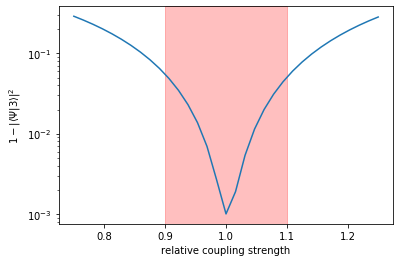

In [21]:
plot_robustness(mu_vals, pop_errors_norobust)

The plot shows that as the pulse amplitude deviates from the optimal value, the
error rises quickly: our previous optimization result is not robust.

The highlighted region of ±10% is our "region of interest" within
which we would like the control to be robust by applying optimal control.

## Setting the ensemble objectives

They central idea of optimizing for robustness is to take multiple copies of
the Hamiltonian, sampling over the space of variations to which would
like to be robust, and optimize over the average of this ensemble.

Here, we sample 5 values of $\mu$ (including the unperturbed $\mu=1$) in the
region of interest, $\mu \in [0.9, 1.1]$.

In [22]:
ensemble_mu = [0.9, 0.95, 1.0, 1.05, 1.1]

The corresponding Hamiltonians are

In [23]:
ham_ensemble = [scale_control(objective.H, mu=mu) for mu in ensemble_mu]

The `krotov.objectives.ensemble_objectives` extends the original objective of a
single unperturbed state-to-state transition with one additional objective for
each ensemble Hamiltonian for $\mu \neq 1$:

In [24]:
ensemble_objectives = krotov.objectives.ensemble_objectives(
    objectives, ham_ensemble, keep_original_objectives=False,
)
ensemble_objectives

[Objective[|Ψ₀(3)⟩ to |Ψ₁(3)⟩ via [H₀[3,3], [H₅[3,3], u₁(t)], [H₆[3,3], u₂(t)], [H₇[3,3], u₃(t)], [H₈[3,3], u₄(t)]]],
 Objective[|Ψ₀(3)⟩ to |Ψ₁(3)⟩ via [H₀[3,3], [H₉[3,3], u₁(t)], [H₁₀[3,3], u₂(t)], [H₁₁[3,3], u₃(t)], [H₁₂[3,3], u₄(t)]]],
 Objective[|Ψ₀(3)⟩ to |Ψ₁(3)⟩ via [H₀[3,3], [H₁₃[3,3], u₁(t)], [H₁₄[3,3], u₂(t)], [H₁₅[3,3], u₃(t)], [H₁₆[3,3], u₄(t)]]],
 Objective[|Ψ₀(3)⟩ to |Ψ₁(3)⟩ via [H₀[3,3], [H₁₇[3,3], u₁(t)], [H₁₈[3,3], u₂(t)], [H₁₉[3,3], u₃(t)], [H₂₀[3,3], u₄(t)]]],
 Objective[|Ψ₀(3)⟩ to |Ψ₁(3)⟩ via [H₀[3,3], [H₂₁[3,3], u₁(t)], [H₂₂[3,3], u₂(t)], [H₂₃[3,3], u₃(t)], [H₂₄[3,3], u₄(t)]]]]

It is important that all five objectives reference the same four control
pulses, as is the case here.

## Optimize

We use the same update shape $S(t)$ and $\lambda_a$ value as in the original optimization:

In [25]:
def S(t):
    """Scales the Krotov methods update of the pulse value at the time t"""
    return krotov.shapes.flattop(t, 0.0, 5, 0.3, func='sinsq')


λ = 0.5

pulse_options = {
    H[1][1]: dict(lambda_a=λ, update_shape=S),
    H[2][1]: dict(lambda_a=λ, update_shape=S),
    H[3][1]: dict(lambda_a=λ, update_shape=S),
    H[4][1]: dict(lambda_a=λ, update_shape=S),
}

It will be interesting to see how the optimization progresses for each
individual element of the ensemble. Thus, we write an `info_hook` routine that
prints out a tabular overview of $1 - \Re\Braket{\Psi(T)}{3}_{\Op{H}_i}$ for
all $\Op{H}_i$ in the ensemble, as well as their average (the total functional
$J_T$ that is being minimized)









In [26]:
def print_J_T_per_target(**kwargs):
    iteration = kwargs['iteration']
    N = len(ensemble_mu)
    if iteration == 0:
        print(
            "iteration "
            + "%11s " % "J_T(avg)"
            + " ".join([("J_T(μ=%.2f)" % μ) for μ in ensemble_mu])
        )
    J_T_vals = 1 - kwargs['tau_vals'].real
    J_T = np.sum(J_T_vals) / N
    print(
        ("%9d " % iteration)
        + ("%11.2e " % J_T)
        + " ".join([("%11.2e" % v) for v in J_T_vals])
    )

We'll also want to look at the output of ``krotov.info_hooks.print_table``, but
in order to keep the output orderly, we will write that information to a file
`ensemble_opt.log`.

In [27]:
log_fh = open("ensemble_opt.log", "w", encoding="utf-8")

To speed up the optimization slightly, we parallelize across the five
objectives with appropriate `parallel_map` functions.
The optimization starts for the same guess pulses as the original [Optimization
of a State-to-State Transfer in a Lambda System in the
RWA](02_example_lambda_system_rwa_complex_pulse.ipynb). Generally, for a
robustness ensemble optimization, this will yield better results than trying to
take the optimized pulses for the unperturbed system as a guess.


In [28]:
opt_result = krotov.optimize_pulses(
    ensemble_objectives,
    pulse_options,
    tlist,
    propagator=krotov.propagators.expm,
    chi_constructor=krotov.functionals.chis_re,
    info_hook=krotov.info_hooks.chain(
        print_J_T_per_target,
        krotov.info_hooks.print_table(
            J_T=krotov.functionals.J_T_re, out=log_fh
        ),
    ),
    check_convergence=krotov.convergence.Or(
        krotov.convergence.value_below(1e-3, name='J_T'),
        krotov.convergence.check_monotonic_error,
    ),
    parallel_map=(
        qutip.parallel_map,
        qutip.parallel_map,
        krotov.parallelization.parallel_map_fw_prop_step,
    ),
    iter_stop=12,
)

iteration    J_T(avg) J_T(μ=0.90) J_T(μ=0.95) J_T(μ=1.00) J_T(μ=1.05) J_T(μ=1.10)
        0    1.01e+00    1.01e+00    1.01e+00    1.01e+00    1.01e+00    1.01e+00
        1    6.79e-01    6.94e-01    6.83e-01    6.75e-01    6.71e-01    6.71e-01
        2    4.14e-01    4.41e-01    4.21e-01    4.07e-01    4.00e-01    4.00e-01
        3    2.36e-01    2.68e-01    2.43e-01    2.27e-01    2.20e-01    2.23e-01
        4    1.32e-01    1.63e-01    1.37e-01    1.21e-01    1.16e-01    1.22e-01
        5    7.46e-02    1.04e-01    7.78e-02    6.29e-02    5.98e-02    6.86e-02
        6    4.47e-02    7.13e-02    4.58e-02    3.24e-02    3.13e-02    4.26e-02
        7    2.92e-02    5.32e-02    2.88e-02    1.66e-02    1.72e-02    3.04e-02
        8    2.14e-02    4.32e-02    1.96e-02    8.59e-03    1.04e-02    2.50e-02
        9    1.73e-02    3.74e-02    1.46e-02    4.48e-03    7.25e-03    2.28e-02
       10    1.52e-02    3.41e-02    1.19e-02    2.38e-03    5.83e-03    2.21e-02
       11    1.4

After twelve iterations (which were sufficient to produce an error $<10^{-3}$
in the original optimization), we find the average error over the ensemble to
be still above $>10^{-2}$. However, the error for $\mu = 1$ is only *slightly*
larger than in the original optimization; the lack of success is entirely due
to the large error for the other elements of the ensemble for $\mu \neq 1$.
Achieving robustness is hard!

We continue the optimization until the *average* error falls below $10^{-3}$:


In [29]:
dumpfile = "./ensemble_opt_result.dump"
if os.path.isfile(dumpfile):
    opt_result = krotov.result.Result.load(dumpfile, objectives)
    print_J_T_per_target(iteration=0, tau_vals=opt_result.tau_vals[12])
    print("      ...")
    n_iters = len(opt_result.tau_vals)
    for i in range(n_iters - 10, n_iters):
        print_J_T_per_target(iteration=i, tau_vals=opt_result.tau_vals[i])
else:
    opt_result = krotov.optimize_pulses(
        ensemble_objectives,
        pulse_options,
        tlist,
        propagator=krotov.propagators.expm,
        chi_constructor=krotov.functionals.chis_re,
        info_hook=krotov.info_hooks.chain(
            print_J_T_per_target,
            krotov.info_hooks.print_table(
                J_T=krotov.functionals.J_T_re, out=log_fh
            ),
        ),
        check_convergence=krotov.convergence.Or(
            krotov.convergence.value_below(1e-3, name='J_T'),
            krotov.convergence.check_monotonic_error,
        ),
        parallel_map=(
            qutip.parallel_map,
            qutip.parallel_map,
            krotov.parallelization.parallel_map_fw_prop_step,
        ),
        iter_stop=1000,
        continue_from=opt_result,
    )
    opt_result.dump(dumpfile)

iteration    J_T(avg) J_T(μ=0.90) J_T(μ=0.95) J_T(μ=1.00) J_T(μ=1.05) J_T(μ=1.10)
        0    1.36e-02    3.07e-02    9.37e-03    7.20e-04    5.00e-03    2.20e-02
      ...
      670    1.05e-03    2.80e-03    4.83e-04    1.10e-04    5.22e-04    1.34e-03
      671    1.05e-03    2.79e-03    4.79e-04    1.10e-04    5.20e-04    1.33e-03
      672    1.04e-03    2.77e-03    4.76e-04    1.10e-04    5.17e-04    1.33e-03
      673    1.03e-03    2.76e-03    4.73e-04    1.11e-04    5.14e-04    1.32e-03
      674    1.03e-03    2.74e-03    4.70e-04    1.11e-04    5.11e-04    1.31e-03
      675    1.02e-03    2.72e-03    4.66e-04    1.11e-04    5.08e-04    1.30e-03
      676    1.02e-03    2.71e-03    4.63e-04    1.12e-04    5.06e-04    1.29e-03
      677    1.01e-03    2.69e-03    4.60e-04    1.12e-04    5.03e-04    1.28e-03
      678    1.00e-03    2.68e-03    4.57e-04    1.12e-04    5.00e-04    1.27e-03
      679    9.99e-04    2.67e-03    4.54e-04    1.13e-04    4.98e-04    1.27e-03


In [30]:
opt_result

Krotov Optimization Result
--------------------------
- Started at 2019-12-14 07:18:32
- Number of objectives: 1
- Number of iterations: 679
- Reason for termination: Reached convergence: J_T < 0.001
- Ended at 2019-12-14 09:49:45 (2:31:13)

In [31]:
log_fh.close()

Even now, the ideal Hamiltonian ($\mu = 1$) has the lowest error in the
ensemble by a significant margin. However, notice that the error in the $J_T$
for $\mu = 1$ is actually rising, while the errors for values of $\mu \neq 1$
are falling by a much larger value! This is a good thing: we sacrifice a little
bit of fidelity in the unperturbed dynamics to an increase in robustness.

The optimized "robust" pulse looks as follows:

pump pulse amplitude and phase:


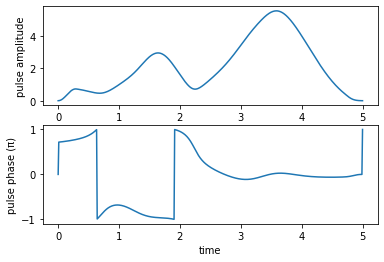

Stokes pulse amplitude and phase:


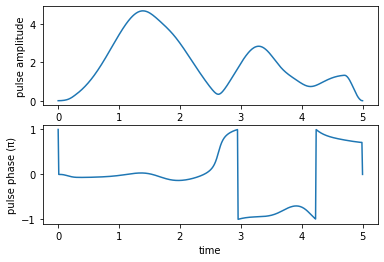

In [32]:
def plot_pulse_amplitude_and_phase(pulse_real, pulse_imaginary, tlist):
    ax1 = plt.subplot(211)
    ax2 = plt.subplot(212)
    amplitudes = [
        np.sqrt(x * x + y * y) for x, y in zip(pulse_real, pulse_imaginary)
    ]
    phases = [
        np.arctan2(y, x) / np.pi for x, y in zip(pulse_real, pulse_imaginary)
    ]
    ax1.plot(tlist, amplitudes)
    ax1.set_xlabel('time')
    ax1.set_ylabel('pulse amplitude')
    ax2.plot(tlist, phases)
    ax2.set_xlabel('time')
    ax2.set_ylabel('pulse phase (π)')
    plt.show()


print("pump pulse amplitude and phase:")
plot_pulse_amplitude_and_phase(
    opt_result.optimized_controls[0], opt_result.optimized_controls[1], tlist
)
print("Stokes pulse amplitude and phase:")
plot_pulse_amplitude_and_phase(
    opt_result.optimized_controls[2], opt_result.optimized_controls[3], tlist
)

and produces the dynamics (in the unperturbed system) shown below:

In [33]:
opt_robust_dynamics = opt_result.optimized_objectives[0].mesolve(
    tlist, e_ops=[proj1, proj2, proj3]
)

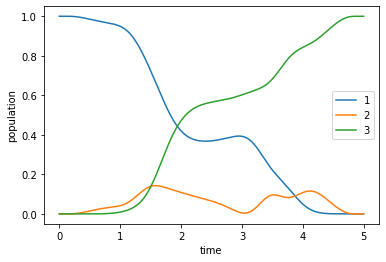

In [34]:
plot_population(opt_robust_dynamics)

### Robustness analysis

When comparing the robustness of the "robust" optimized pulse to that obtained
from the original optimization for the unperturbed Hamiltonian, we should make
sure that we have converged to a comparable error: We would like to avoid the
suspicion that the ensemble error is below our threshold only because the error
for $\mu = 1$ is so much lower. Therefore, we continue the original unperturbed
optimization for a few more iterations, until we reach the same error $\approx
1.13 \times 10^{-4}$ that we found as the result of the ensemble optimization,
looking at $\mu=1$ only:

In [35]:
print("J_T(μ=1) = %.2e" % (1 - opt_result.tau_vals[-1][0].real))

J_T(μ=1) = 2.67e-03


In [36]:
opt_result_unperturbed_cont = krotov.optimize_pulses(
    [objective],
    pulse_options,
    tlist,
    propagator=krotov.propagators.expm,
    chi_constructor=krotov.functionals.chis_re,
    info_hook=krotov.info_hooks.print_table(
        J_T=krotov.functionals.J_T_re,
        show_g_a_int_per_pulse=True,
    ),
    check_convergence=krotov.convergence.Or(
        krotov.convergence.value_below(1.13e-4, name='J_T'),
        krotov.convergence.check_monotonic_error,
    ),
    iter_stop=50,
    continue_from=opt_result_unperturbed,
)

iter.      J_T  ∫gₐ(ϵ₁)dt  ∫gₐ(ϵ₂)dt  ∫gₐ(ϵ₃)dt  ∫gₐ(ϵ₄)dt   ∑∫gₐ(t)dt          J       ΔJ_T         ΔJ  secs
0     5.91e-04   0.00e+00   0.00e+00   0.00e+00   0.00e+00    0.00e+00   5.91e-04        n/a        n/a     1
13    3.25e-04   1.26e-04   1.98e-05   1.02e-04   1.84e-05    2.66e-04   5.90e-04  -2.66e-04  -3.54e-07     3
14    1.83e-04   6.32e-05   1.41e-05   5.12e-05   1.29e-05    1.41e-04   3.24e-04  -1.42e-04  -2.11e-07     3
15    1.06e-04   3.19e-05   1.00e-05   2.59e-05   9.11e-06    7.69e-05   1.83e-04  -7.70e-05  -1.27e-07     3


Now, we can compare the robustness of the optimized pulses from the original
unperturbed optimization (label "-1"), the continued unperturbed optimization
(label "0"), and the ensemble optimization (label "1"):

In [37]:
def _f(mu):
    return pop_error(
        opt_result_unperturbed_cont.optimized_objectives[0], mu=mu
    )


pop_errors_norobust_cont = parallel_map(_f, mu_vals)

In [38]:
def _f(mu):
    return pop_error(opt_result.optimized_objectives[0], mu=mu)


pop_errors_robust = parallel_map(_f, mu_vals)

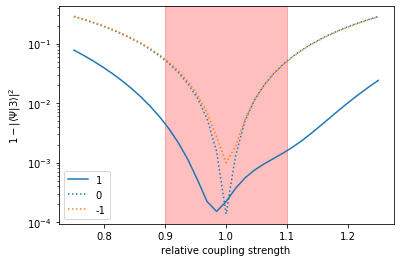

In [39]:
plot_robustness(
    mu_vals,
    pop_errors_robust,
    pop_errors0=[pop_errors_norobust_cont, pop_errors_norobust],
)

We see that without the ensemble optimization, we only lower the error for
exactly $\mu = 1$: the more we converge, the less robust the result. In
contrast, the ensemble optimization results in considerably lower errors (order
of magnitude!) throughout the highlighted "region of interest" and beyond.